In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
import time   
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

/home/partha/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/partha/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/partha/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/partha/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
def start_data_augmentation(source_folder,destination_folder,number_of_samples):

    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in tqdm(listdir(source_folder)):
        image = cv2.imread(source_folder + '/' + filename)
        image = image.reshape((1,)+image.shape)
        prefix_name = 'augmented_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=destination_folder, 
                                           save_prefix=prefix_name, save_format='jpg'):
            i += 1
            if i > number_of_samples:
                break

In [3]:
start_time = datetime.now()
positive_path = "/home/partha/MY_DRIVES/Program_Files/HomeWork/6/Data/yes/"
negative_path = "/home/partha/MY_DRIVES/Program_Files/HomeWork/6/Data/no/"
augmented_data_path = '/home/partha/MY_DRIVES/Program_Files/HomeWork/6/Data/augmented_data/'
start_data_augmentation(positive_path,augmented_data_path+'yes',6)
start_data_augmentation(negative_path, augmented_data_path+'no',9)
end_time = datetime.now()
execution_time = (end_time - start_time).seconds

100%|██████████| 98/98 [00:50<00:00,  1.86it/s]


In [4]:
def crop_from_contour(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]  
    return new_image

In [5]:
def load_dataset(path_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    
    for path in path_list:
        for file_name in listdir(path):
            image = cv2.imread(path + '/' + file_name)
            image = crop_from_contour(image)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if path[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    return X, y

In [6]:

augmented_yes = augmented_data_path + 'yes' 
augmented_no = augmented_data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_dataset([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [7]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [8]:
def get_CNN_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    model = Model(inputs = X_input, outputs = X, name='TumorDetectionModel')
    return model

In [9]:
model = get_CNN_model((IMG_WIDTH, IMG_HEIGHT, 3))

W0913 10:00:55.389733 139813950306112 deprecation.py:506] From /home/partha/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "TumorDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W0913 10:00:55.708895 139813950306112 deprecation.py:323] From /home/partha/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
log_file_name = f'tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')
check_point_format="/home/partha/MY_DRIVES/Program_Files/HomeWork/6/CheckPoint/cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
checkpoint = ModelCheckpoint("{}.model".format(check_point_format, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) 

In [20]:
start_time = datetime.now()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=12, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = datetime.now()
execution_time = (end_time - start_time).seconds
print(str(execution_time) +"s")

Train on 1650 samples, validate on 207 samples
Epoch 1/12
1650/1650 [==============================] - 67s 41ms/sample - loss: 0.2612 - acc: 0.8964 - val_loss: 0.4200 - val_acc: 0.7923
Epoch 2/12
1650/1650 [==============================] - 72s 43ms/sample - loss: 0.2618 - acc: 0.8964 - val_loss: 0.6737 - val_acc: 0.6473
Epoch 3/12
1650/1650 [==============================] - 73s 44ms/sample - loss: 0.2423 - acc: 0.9042 - val_loss: 0.3608 - val_acc: 0.8406
Epoch 4/12
1650/1650 [==============================] - 73s 44ms/sample - loss: 0.1962 - acc: 0.9327 - val_loss: 0.3650 - val_acc: 0.8454
Epoch 5/12
1650/1650 [==============================] - 76s 46ms/sample - loss: 0.1932 - acc: 0.9261 - val_loss: 0.3507 - val_acc: 0.8551
Epoch 6/12
1650/1650 [==============================] - 80s 49ms/sample - loss: 0.2262 - acc: 0.9030 - val_loss: 0.3434 - val_acc: 0.8454
Epoch 7/12
1650/1650 [==============================] - 100s 61ms/sample - loss: 0.1642 - acc: 0.9442 - val_loss: 0.3787 - va

In [16]:
def plot_training_history(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


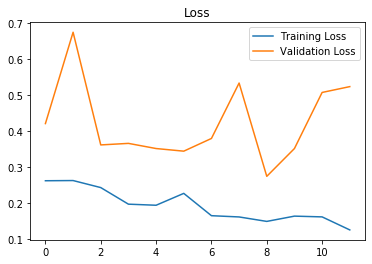

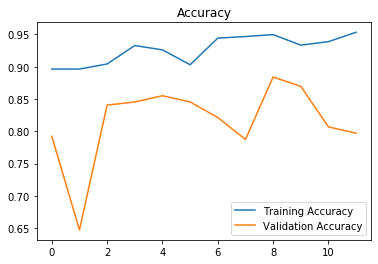

In [21]:
history = model.history.history
plot_training_history(history)

In [22]:
saved_model = load_model(filepath='/home/partha/MY_DRIVES/Program_Files/HomeWork/6/CheckPoint/cnn-parameters-improvement-05-0.85.model')
loss, acc = saved_model.evaluate(x=X_test, y=y_test)

206/206 [==============================] - 2s 10ms/sample - loss: 0.4554 - acc: 0.7961


In [23]:
print(loss)
print(acc)

0.455415170458914
0.79611653
